# 4.5.1 Exercises: Bayesian t-test

We will do something equivalent to the t-test using Stan. 

Using the data generated 
from the following R code, we want to decide whether the mean parameter μ1 in 
group one (Y1) differs from μ2 in group two (Y2) by computing Prob[μ1 <μ2], 
which is the probability of μ1 <μ2. 
```
set.seed(123) 
N1<-30 
N2<-20 
Y1 <- rnorm(n=N1, mean=0, sd=5) 
Y2 <- rnorm(n=N2, mean=1, sd=4) 
```
1. Visualize the data from these two groups so that we can intuitively see whether 
the difference exists between them. 
2. Write a model formula with the assumption that these two groups have the same 
SD. This corresponds to the Students’ t-test. 
3. Create the model file of (2) in Stan and estimate the parameters. Don’t use 
generated quantities block here yet, because in the next (4) we will 
be practicing how to make use of draws from R or Python. 
4. Compute Prob[μ1 <μ2] from the obtained draws using R or Python (hint: we 
can count how many times the event μ1 <μ2 occurrs in the entire draws, and 
divide this quantity by the total number of draws). 
5. Write a model formula with the assumption that the two SDs are different. This 
is equivalent to the Welch’s t-test. Similarly, compute Prob[μ1 <μ2].

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cmdstanpy import CmdStanModel
import os

In [83]:
# --- (1) Data Generation and Visualization ---

# Set a seed for reproducibility
rng = np.random.default_rng(123)

# Define data parameters
N1 = 30
N2 = 20
mean1, sd1 = 0, 5
mean2, sd2 = 1, 4

# Generate the data
Y1 = rng.normal(loc=mean1, scale=sd1, size=N1)
Y2 = rng.normal(loc=mean2, scale=sd2, size=N2)

print("--- Data Generation ---")
print(f"Generated {N1} data points for Group 1.")
print(f"Generated {N2} data points for Group 2.\n")


--- Data Generation ---
Generated 30 data points for Group 1.
Generated 20 data points for Group 2.



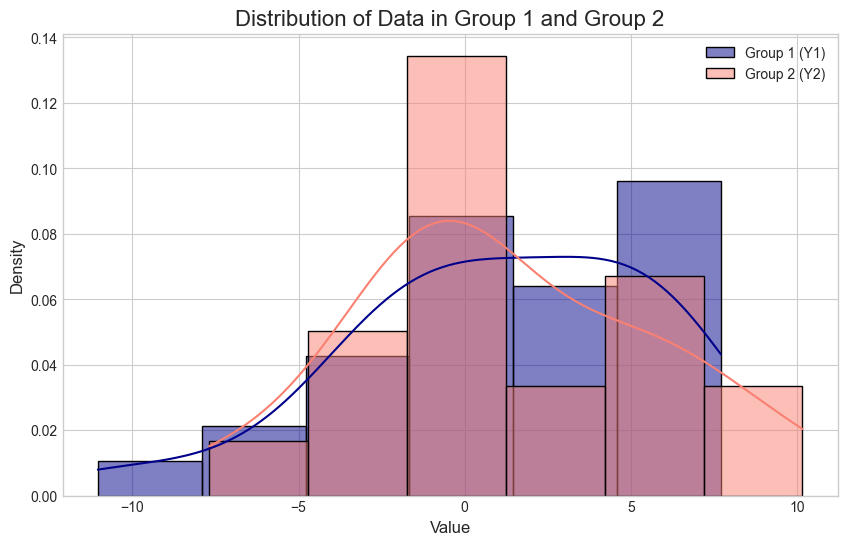

In [84]:
# Visualize the data
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(Y1, kde=True, label='Group 1 (Y1)', color='darkblue', stat='density', common_norm=False)
sns.histplot(Y2, kde=True, label='Group 2 (Y2)', color='salmon', stat='density', common_norm=False)
ax.set_title('Distribution of Data in Group 1 and Group 2', fontsize=16)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend()
plt.show()

## t-Test in Classical Statistics

In [85]:
from scipy.stats import ttest_ind


print("--- Classical t-test ---")
print("Data Sizes: ", Y1.shape, Y2.shape)

t_stat, p_value = ttest_ind(Y1, Y2, equal_var=True)
print(f"Student's t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

--- Classical t-test ---
Data Sizes:  (30,) (20,)
Student's t-test: t-statistic = -0.0867, p-value = 0.9313


The output:

Student's t-test: t-statistic = -0.0867, p-value = 0.9313

means:

- **t-statistic**: -0.0867  
  This value measures the difference between the means of `Y1` and `Y2` relative to the variation in your data. A value close to zero indicates the means are very similar.

- **p-value**: 0.9313  
  This is the probability of observing a difference as extreme as (or more extreme than) the one measured, assuming the null hypothesis (that the means are equal) is true.  
  A p-value near 1 (like 0.9313) means there is **no evidence** to reject the null hypothesis; the two groups are statistically indistinguishable in terms of their means.

**Conclusion:**  
There is no significant difference between the means of `Y1` and `Y2`.

## Bayesian Modeling

In [86]:
# --- (2) & (3) Model with Equal SD (Student's t-test equivalent) ---

print("\n--- Model 1: Assuming Equal Standard Deviations ---")

# The model formula can be written as:
# Y1_i ~ Normal(mu1, sigma) for i = 1,...,N1
# Y2_j ~ Normal(mu2, sigma) for j = 1,...,N2
# mu1 ~ Normal(0, 10)  (Weakly informative prior)
# mu2 ~ Normal(0, 10)  (Weakly informative prior)
# sigma ~ Cauchy(0, 5) (Weakly informative prior, sigma > 0)

# Create the Stan model file
stan_code_equal_sd = """
data {
  int<lower=0> N1; // Number of data points in group 1
  int<lower=0> N2; // Number of data points in group 2
  vector[N1] Y1;   // Data for group 1
  vector[N2] Y2;   // Data for group 2
}
parameters {
  real mu1;              // Mean of group 1
  real mu2;              // Mean of group 2
  real<lower=0> sigma;   // Common standard deviation
}
model {
  // Priors (weakly informative)
  mu1 ~ normal(0, 10);
  mu2 ~ normal(0, 10);
  sigma ~ cauchy(0, 5);

  // Likelihood
  Y1 ~ normal(mu1, sigma);
  Y2 ~ normal(mu2, sigma);
}
"""

# Save the model to a file
from pathlib import Path
stan_file_equal_sd = Path('model/model_equal_sd.stan')
stan_file_equal_sd.parent.mkdir(parents=True, exist_ok=True)
with open(stan_file_equal_sd, 'w') as f:
    f.write(stan_code_equal_sd)

# Prepare data for Stan
stan_data = {'N1': N1, 'N2': N2, 'Y1': Y1, 'Y2': Y2}

# Compile and fit the model
print("Compiling Stan model (equal SDs)...")
model_equal_sd = CmdStanModel(stan_file=stan_file_equal_sd)

print("Fitting model...")
fit_equal_sd = model_equal_sd.sample(data=stan_data, seed=123, chains=4, parallel_chains=4)



--- Model 1: Assuming Equal Standard Deviations ---
Compiling Stan model (equal SDs)...


12:10:31 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model\model_equal_sd.stan to exe file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model\model_equal_sd.exe
12:10:39 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model\model_equal_sd.exe


Fitting model...


12:10:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


12:10:39 - cmdstanpy - INFO - CmdStan done processing.


In [87]:
# Display summary statistics of the parameters
print("\nParameter summary for the equal SD model:")
print(fit_equal_sd.summary())


Parameter summary for the equal SD model:
            Mean      MCSE    StdDev       MAD          5%       50%  \
lp__  -100.31400  0.031953  1.275460  1.041520 -102.868000 -99.98080   
mu1      1.08414  0.013518  0.833420  0.813998   -0.289797   1.09572   
mu2      1.22130  0.016975  1.032160  1.020760   -0.445884   1.22375   
sigma    4.62877  0.008493  0.486264  0.471603    3.917220   4.58979   

            95%  ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__  -98.94290   1687.17   2415.27     29089.1  1.00201  
mu1     2.46637   3827.68   2852.80     65994.4  1.00124  
mu2     2.93348   3735.64   2406.62     64407.5  1.00039  
sigma   5.50496   3533.70   2876.26     60925.9  1.00021  


In [88]:
# --- (4) Compute Prob[mu1 < mu2] for the Equal SD Model ---

# Extract draws into a pandas DataFrame
draws_equal_sd = fit_equal_sd.draws_pd()

# Calculate the probability
prob_mu1_lt_mu2_equal = (draws_equal_sd['mu1'] < draws_equal_sd['mu2']).mean()

print("--- Analysis for Equal SD Model ---")
print(f"Probability (mu1 < mu2): {prob_mu1_lt_mu2_equal:.4f}")

--- Analysis for Equal SD Model ---
Probability (mu1 < mu2): 0.5353


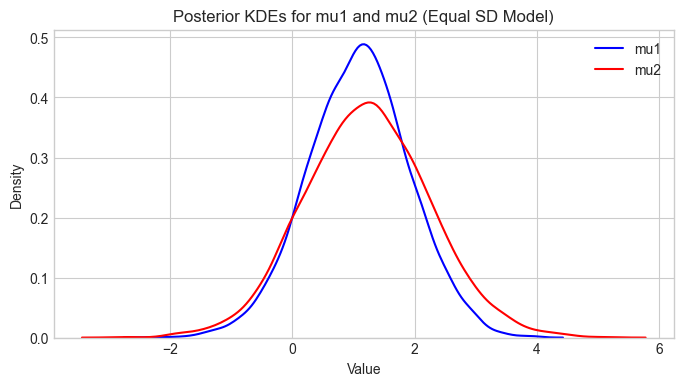

In [89]:
plt.figure(figsize=(8, 4))
sns.kdeplot(draws_equal_sd['mu1'], label='mu1', color='blue')
sns.kdeplot(draws_equal_sd['mu2'], label='mu2', color='red')
plt.title('Posterior KDEs for mu1 and mu2 (Equal SD Model)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

The value `prob_mu1_lt_mu2_equal = 0.5353` means:

- After fitting the Bayesian model (with equal standard deviations for both groups), you sampled many possible values for the means `mu1` and `mu2`.
- For each sample, you checked if `mu1 < mu2`.
- The result `0.5353` is the proportion of samples where `mu1` was less than `mu2`.

**Interpretation:**  
There is a 53.53% posterior probability that the mean of group 1 (`mu1`) is less than the mean of group 2 (`mu2`), given your data and model assumptions.  
This probability is close to 0.5, indicating little evidence for a difference in means between

---

## Another Stan model: $\mu_2 = \mu_1 + \delta$

In [90]:
# --- (2) & (3) Model with Equal SD (Student's t-test equivalent) ---
print("--- Model 1: Assuming Equal Standard Deviations ---")

# The model formula can be written as:
# Y1_i ~ Normal(mu1, sigma) for i = 1,...,N1
# Y2_j ~ Normal(mu2, sigma) for j = 1,...,N2
# mu1 ~ Normal(0, 10)  (Weakly informative prior)
# delta ~ Normal(0, 1)  (Weakly informative prior)
# mu2 = mu1 + delta  (Difference in means)
# sigma ~ Cauchy(0, 5) (Weakly informative prior, sigma > 0)

# Create the Stan model file
stan_code_equal_sd = """
data {
  int<lower=0> N1; // Number of data points in group 1
  int<lower=0> N2; // Number of data points in group 2
  vector[N1] Y1;   // Data for group 1
  vector[N2] Y2;   // Data for group 2
}
parameters {
  real mu1;              // Mean of group 1
  real delta;              // Mean of group 2
  real<lower=0> sigma;   // Common standard deviation
}

transformed parameters {
  real mu2 = mu1 + delta; // Mean of group 2
}

model {
  // Priors (weakly informative)
  mu1 ~ normal(0, 10);
  delta ~ normal(0, 1);
  sigma ~ cauchy(0, 5);

  // Likelihood
  Y1 ~ normal(mu1, sigma);
  Y2 ~ normal(mu2, sigma);
}
"""

# Save the model to a file
stan_file_equal_sd = 'model/model_equal_sd_delta.stan'
with open(stan_file_equal_sd, 'w') as f:
    f.write(stan_code_equal_sd)

# Prepare data for Stan
stan_data = {'N1': N1, 'N2': N2, 'Y1': Y1, 'Y2': Y2}

# Compile and fit the model
print("Compiling Stan model (equal SDs)...")
model_equal_sd = CmdStanModel(stan_file=stan_file_equal_sd)

print("Fitting model...")
fit_equal_sd = model_equal_sd.sample(data=stan_data, seed=123, chains=4, parallel_chains=4)


--- Model 1: Assuming Equal Standard Deviations ---
Compiling Stan model (equal SDs)...


12:10:40 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model\model_equal_sd_delta.stan to exe file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model\model_equal_sd_delta.exe
12:10:48 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model\model_equal_sd_delta.exe


Fitting model...


12:10:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


12:10:48 - cmdstanpy - INFO - CmdStan done processing.
12:10:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_equal_sd_delta.stan', line 25, column 2 to column 26)
Consider re-running with show_console=True if the above output is unclear!


In [91]:
samples = fit_equal_sd.draws_pd()
samples[['mu1', 'delta', 'sigma']].describe()

,mu1,delta,sigma
count,4000.000000,4000.000000,4000.000000
mean,1.127894,0.037191,4.591518
std,0.715871,0.787626,0.465854
min,-1.846255,-3.022697,3.344209
25%,0.640121,-0.492830,4.266236
50%,1.136984,0.024006,4.558579
75%,1.623774,0.563394,4.869469
max,3.799740,2.754250,6.839684


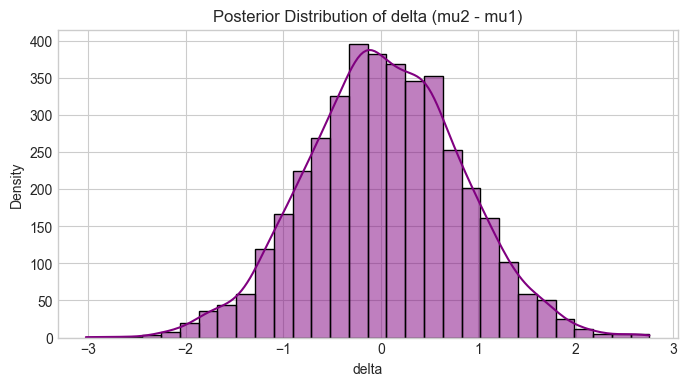

In [92]:
plt.figure(figsize=(8, 4))
sns.histplot(samples['delta'], kde=True, color='purple', bins=30)
plt.title('Posterior Distribution of delta (mu2 - mu1)')
plt.xlabel('delta')
plt.ylabel('Density')
plt.show()

---

## Unequal SD Model

In [93]:
# --- (5) Model with Unequal SD (Welch's t-test equivalent) ---

print("--- Model 2: Assuming Unequal Standard Deviations ---")

# The model formula can be written as:
# Y1_i ~ Normal(mu1, sigma1) for i = 1,...,N1
# Y2_j ~ Normal(mu2, sigma2) for j = 1,...,N2
# mu1 ~ Normal(0, 10)
# mu2 ~ Normal(0, 10)
# sigma1 ~ Cauchy(0, 5) (sigma1 > 0)
# sigma2 ~ Cauchy(0, 5) (sigma2 > 0)

# Create the Stan model file
stan_code_unequal_sd = """
data {
  int<lower=0> N1;
  int<lower=0> N2;
  vector[N1] Y1;
  vector[N2] Y2;
}
parameters {
  real mu1;
  real mu2;
  real<lower=0> sigma1; // Separate SD for group 1
  real<lower=0> sigma2; // Separate SD for group 2
}
model {
  // Priors
  mu1 ~ normal(0, 10);
  mu2 ~ normal(0, 10);
  sigma1 ~ cauchy(0, 5);
  sigma2 ~ cauchy(0, 5);

  // Likelihood
  Y1 ~ normal(mu1, sigma1);
  Y2 ~ normal(mu2, sigma2);
}
"""

# Save the model to a file
stan_file_unequal_sd = 'model_unequal_sd.stan'
with open(stan_file_unequal_sd, 'w') as f:
    f.write(stan_code_unequal_sd)

# Compile and fit the model (data is the same)
print("Compiling Stan model (unequal SDs)...")
model_unequal_sd = CmdStanModel(stan_file=stan_file_unequal_sd)
print("Fitting model...")
fit_unequal_sd = model_unequal_sd.sample(data=stan_data, seed=123, chains=4, parallel_chains=4)


12:10:49 - cmdstanpy - INFO - compiling stan file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model_unequal_sd.stan to exe file C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model_unequal_sd.exe


--- Model 2: Assuming Unequal Standard Deviations ---
Compiling Stan model (unequal SDs)...


12:10:57 - cmdstanpy - INFO - compiled model executable: C:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\yndk\ch04\model_unequal_sd.exe


Fitting model...


12:10:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


12:10:57 - cmdstanpy - INFO - CmdStan done processing.


In [94]:
fit_unequal_sd.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-99.89870,0.033322,1.456430,1.220870,-102.646000,-99.54370,-98.22760,1986.93,2582.92,29219.6,1.002020
mu1,1.11601,0.014715,0.879021,0.841526,-0.317167,1.11925,2.53393,3649.00,2665.44,53661.8,1.001650
mu2,1.19708,0.017319,1.055450,1.023640,-0.540077,1.19880,2.93220,3748.69,2455.58,55127.8,1.000790
sigma1,4.70947,0.010040,0.616608,0.608224,3.804020,4.65371,5.79447,4034.18,2717.60,59326.2,0.999634
sigma2,4.66933,0.013389,0.778519,0.720957,3.605770,4.57185,6.10461,3613.10,2991.90,53133.8,1.000920


In [95]:
# Compute Prob[mu1 < mu2] for the unequal SD model
draws_unequal_sd = fit_unequal_sd.draws_pd()
prob_mu1_lt_mu2_unequal = (draws_unequal_sd['mu1'] < draws_unequal_sd['mu2']).mean()

print("\n--- Analysis for Unequal SD Model ---")
print(f"Probability (mu1 < mu2): {prob_mu1_lt_mu2_unequal:.4f}\n")


--- Analysis for Unequal SD Model ---
Probability (mu1 < mu2): 0.5205



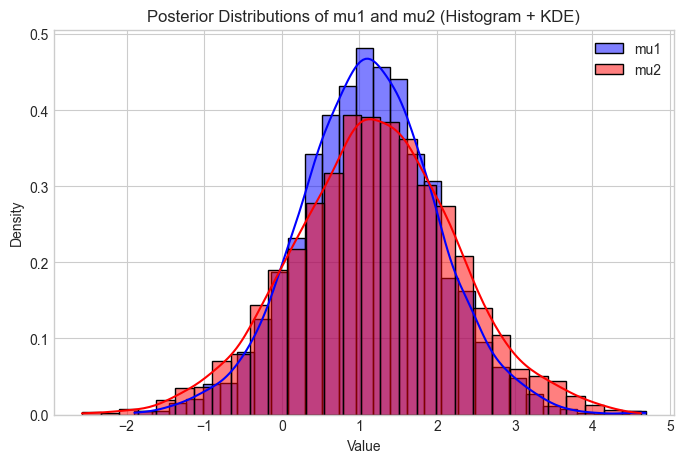

In [96]:
plt.figure(figsize=(8, 5))
sns.histplot(draws_unequal_sd['mu1'], color='blue', label='mu1', kde=True, stat='density', bins=30, alpha=0.5)
sns.histplot(draws_unequal_sd['mu2'], color='red', label='mu2', kde=True, stat='density', bins=30, alpha=0.5)
plt.title('Posterior Distributions of mu1 and mu2 (Histogram + KDE)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

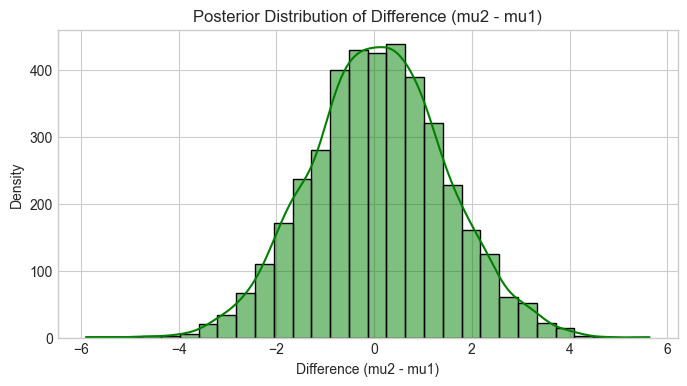

In [97]:
diff = draws_unequal_sd['mu2'] - draws_unequal_sd['mu1']
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, color='green', bins=30)
plt.title('Posterior Distribution of Difference (mu2 - mu1)')
plt.xlabel('Difference (mu2 - mu1)')
plt.ylabel('Density');

- Only one more unknown parameter is added to the equal-sd model. 
- No more data is added.
- The result can not be better than before.

---
## Ten times More Data Points

In [98]:
# --- (1) Data Generation and Visualization ---

# Set a seed for reproducibility
rng = np.random.default_rng(123)

# Define data parameters
N1 = 300
N2 = 200
mean1, sd1 = 0, 5
mean2, sd2 = 1, 4

# Generate new data
Y1 = rng.normal(loc=mean1, scale=sd1, size=N1)
Y2 = rng.normal(loc=mean2, scale=sd2, size=N2)

print("--- Data Generation ---")
print(f"Generated {N1} data points for Group 1.")
print(f"Generated {N2} data points for Group 2.\n")

# Prepare data for Stan using the new data
stan_data_new = {'N1': N1, 'N2': N2, 'Y1': Y1, 'Y2': Y2}

--- Data Generation ---
Generated 300 data points for Group 1.
Generated 200 data points for Group 2.



## Data visualization

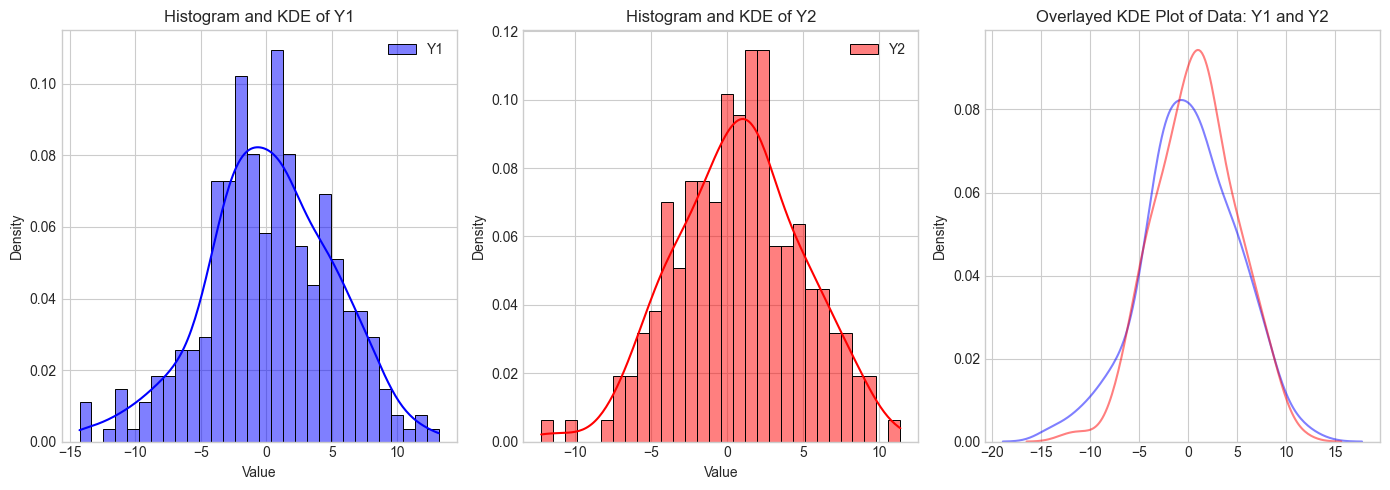

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.histplot(Y1, kde=True, color='blue', label='Y1', stat='density', bins=30, alpha=0.5, ax=axes[0])
axes[0].set_title('Histogram and KDE of Y1')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(Y2, kde=True, color='red', label='Y2', stat='density', bins=30, alpha=0.5, ax=axes[1])
axes[1].set_title('Histogram and KDE of Y2')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.kdeplot(Y1, ax=axes[2], color='blue', label='Y1',  alpha=0.5)
sns.kdeplot(Y2, ax=axes[2], color='red', label='Y2',  alpha=0.5)
axes[2].set_title('Overlayed KDE Plot of Data: Y1 and Y2')

plt.tight_layout()
plt.show()

In [100]:
print("Stan code for unequal SD model:")
print(stan_code_unequal_sd)

Stan code for unequal SD model:

data {
  int<lower=0> N1;
  int<lower=0> N2;
  vector[N1] Y1;
  vector[N2] Y2;
}
parameters {
  real mu1;
  real mu2;
  real<lower=0> sigma1; // Separate SD for group 1
  real<lower=0> sigma2; // Separate SD for group 2
}
model {
  // Priors
  mu1 ~ normal(0, 10);
  mu2 ~ normal(0, 10);
  sigma1 ~ cauchy(0, 5);
  sigma2 ~ cauchy(0, 5);

  // Likelihood
  Y1 ~ normal(mu1, sigma1);
  Y2 ~ normal(mu2, sigma2);
}



In [101]:
# --- (5) Model with Unequal SD (Welch's t-test equivalent) ---
print("--- Model 2: Assuming Unequal Standard Deviations ---")
print("Fitting model...")
fit_unequal_sd_many = model_unequal_sd.sample(data=stan_data_new, seed=123, chains=4, parallel_chains=4)


12:10:58 - cmdstanpy - INFO - CmdStan start processing


--- Model 2: Assuming Unequal Standard Deviations ---
Fitting model...


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


12:10:58 - cmdstanpy - INFO - CmdStan done processing.
12:10:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_unequal_sd.stan', line 22, column 2 to column 27)
Consider re-running with show_console=True if the above output is unclear!


In [102]:
fit_unequal_sd_many.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-1005.950000,0.029931,1.411990,1.203280,-1008.740000,-1005.630000,-1004.300000,2146.52,2969.44,27519.5,1.000960
mu1,0.202722,0.004097,0.283934,0.288960,-0.264930,0.206679,0.660334,4864.48,3388.76,62365.2,0.999659
mu2,0.810677,0.004117,0.281859,0.285563,0.361754,0.809245,1.277990,4728.21,2927.49,60618.1,1.002220
sigma1,4.858980,0.002872,0.196361,0.196607,4.549760,4.852450,5.180050,4750.44,3224.76,60903.1,0.999762
sigma2,4.135840,0.003146,0.214378,0.206957,3.799890,4.123400,4.501870,4703.30,3128.49,60298.8,1.000350


In [103]:
# Compute Prob[mu1 < mu2] for the unequal SD model
draws_unequal_sd = fit_unequal_sd_many.draws_pd()
prob_mu1_lt_mu2_unequal = (draws_unequal_sd['mu1'] < draws_unequal_sd['mu2']).mean()

print("\n--- Analysis for Unequal SD Model ---")
print(f"Probability (mu1 < mu2): {prob_mu1_lt_mu2_unequal:.4f}\n")


--- Analysis for Unequal SD Model ---
Probability (mu1 < mu2): 0.9367



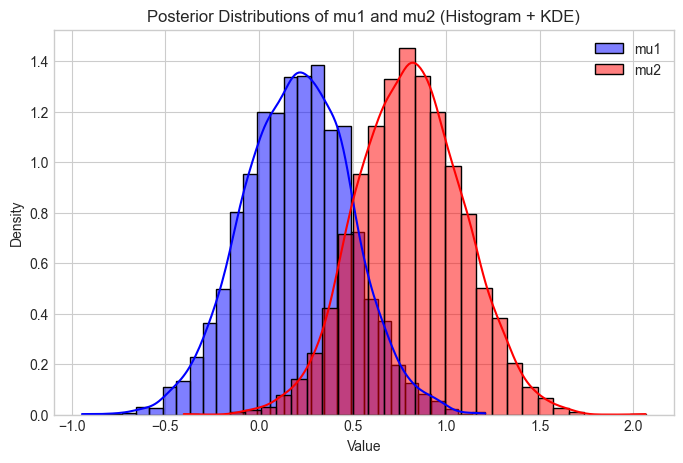


--- Analysis for Unequal SD Model ---
Probability (mu1 < mu2): 0.9367



In [104]:
plt.figure(figsize=(8, 5))
sns.histplot(draws_unequal_sd['mu1'], color='blue', label='mu1', kde=True, stat='density', bins=30, alpha=0.5)
sns.histplot(draws_unequal_sd['mu2'], color='red', label='mu2', kde=True, stat='density', bins=30, alpha=0.5)
plt.title('Posterior Distributions of mu1 and mu2 (Histogram + KDE)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

print("\n--- Analysis for Unequal SD Model ---")
print(f"Probability (mu1 < mu2): {prob_mu1_lt_mu2_unequal:.4f}\n")


--- Analysis for Unequal SD Model ---
Probability (mu1 < mu2): 0.9367



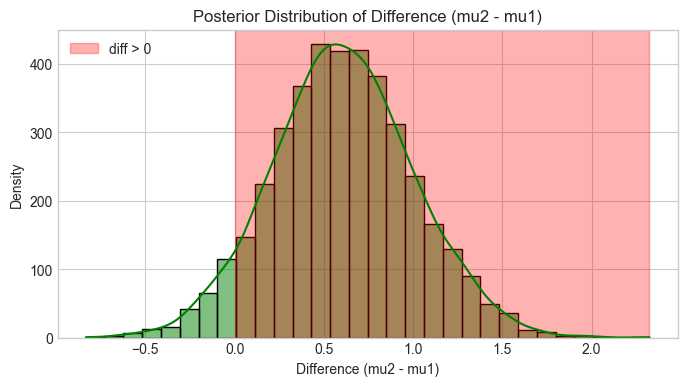

In [105]:
diff = draws_unequal_sd['mu2'] - draws_unequal_sd['mu1']
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, color='green', bins=30)
plt.axvspan(0, diff.max(), color='red', alpha=0.3, label='diff > 0')
plt.legend()
plt.title('Posterior Distribution of Difference (mu2 - mu1)')
plt.xlabel('Difference (mu2 - mu1)')
plt.ylabel('Density');

print("\n--- Analysis for Unequal SD Model ---")
print(f"Probability (mu1 < mu2): {prob_mu1_lt_mu2_unequal:.4f}\n")

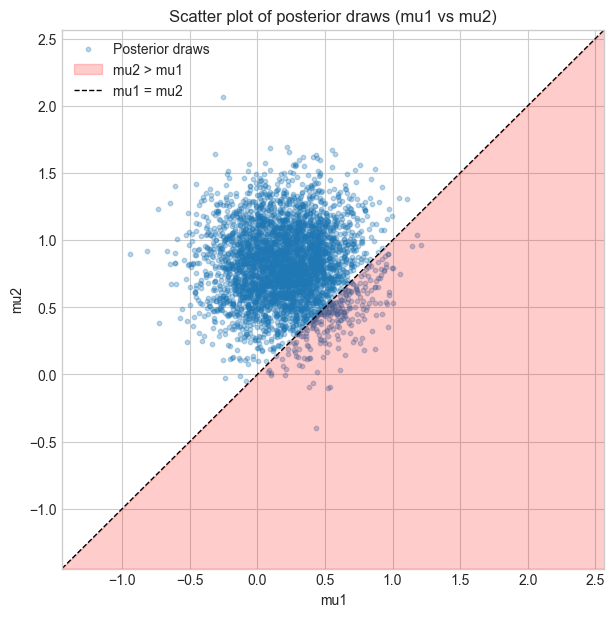


--- Analysis for Unequal SD Model ---
Probability (mu1 < mu2): 0.9367



In [106]:
plt.figure(figsize=(7, 7))
plt.scatter(draws_unequal_sd['mu1'], draws_unequal_sd['mu2'], alpha=0.3, s=10, label='Posterior draws')
plt.xlabel('mu1')
plt.ylabel('mu2')
plt.title('Scatter plot of posterior draws (mu1 vs mu2)')

# Fill the region where mu2 > mu1
lims = (min(draws_unequal_sd['mu1'].min(), draws_unequal_sd['mu2'].min()) - .5,
        max(draws_unequal_sd['mu1'].max(), draws_unequal_sd['mu2'].max()) + .5)
# lims = plt.gca().get_xlim()
plt.fill_betweenx(
    y=np.linspace(*lims, 100),
    x1=np.linspace(*lims, 100),
    x2=lims[1],
    color='red',
    alpha=0.2,
    label='mu2 > mu1'
)
plt.plot(lims, lims, 'k--', lw=1, label='mu1 = mu2')
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.show()

print("\n--- Analysis for Unequal SD Model ---")
print(f"Probability (mu1 < mu2): {prob_mu1_lt_mu2_unequal:.4f}\n")


## t-test in Classical Statistics

In [107]:
from scipy.stats import ttest_ind


print("--- Classical t-test ---")
print("Data Sizes: ", Y1.shape, Y2.shape)

t_stat, p_value = ttest_ind(Y1, Y2, equal_var=False)
print(f"Welch's t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

--- Classical t-test ---
Data Sizes:  (300,) (200,)
Welch's t-test: t-statistic = -1.5295, p-value = 0.1268


The output:

Welch's t-test: t-statistic = -1.5295, p-value = 0.1268

means:

- **t-statistic**: -1.5295  
  This value measures the difference between the means of `Y1` and `Y2`, accounting for unequal variances. A negative value means the mean of `Y1` is less than the mean of `Y2`.

- **p-value**: 0.1268  
  This is the probability of observing a difference as extreme as (or more extreme than) the one measured, assuming the null hypothesis (that the means are equal) is true.  
  A p-value of 0.1268 is greater than the common significance threshold (0.05), so there is **not enough evidence** to reject the null hypothesis.

**Conclusion:**  
There is no statistically significant difference between the means of `Y1` and `Y2`.

--- 
# t-Test: Bayesian vs. Frequentist

## 🎯 The Apparent Contradiction

- **Welch’s t-test** gives a **p-value = 0.1268**, which is **greater than 0.05**, so you **fail to reject the null hypothesis** that the two means are equal.
- **Bayesian modeling** with Stan shows that the **posterior probability that $\mu_1 < \mu_2$ is 0.9367**, suggesting a **high probability** that $\mu_1$ is less than $\mu_2$.

At first glance, this seems contradictory. But it’s not. Here’s why:

---

## 🧪 What the p-value *Actually* Tells You

In Welch’s t-test:
- The **null hypothesis** is $H_0: \mu_1 = \mu_2$.
- The **p-value** is the probability of observing data **as extreme or more extreme** than what you saw, **assuming the null is true**.

So, a p-value of 0.1268 means:

> “If $\mu_1$ and $\mu_2$ were truly equal, there’s a 12.68% chance of seeing data this extreme or more.”

Since 12.68% > 5%, you don’t have strong enough evidence to reject the null. But this **does not mean** the null is true—it just means your data isn’t strong enough to confidently say it’s false.

---

## 📊 What the Bayesian Posterior Tells You

In Bayesian modeling:
- You compute the **posterior distribution** of the parameters given the data.
- The value **0.9367** for $P(\mu_1 < \mu_2 \mid \text{data})$ means:

> “Given the data and prior, there’s a 93.67% probability that $\mu_1$ is less than $\mu_2$.”

This is a **direct probability statement about the parameters**, which is something frequentist methods like the t-test don’t provide.

---

## 🔍 Why the Discrepancy?

### 1. Different Questions

- **Frequentist**: “Assuming no difference, how surprising is this data?”
- **Bayesian**: “Given the data, how probable is it that $\mu_1 < \mu_2$?”

### 2. Use of Priors

- Bayesian methods incorporate **prior beliefs** (even if vague), which can influence the posterior.
- Frequentist methods rely solely on the data at hand.

### 3. Interpretation of Uncertainty

- The p-value is **not** the probability that the null is true.
- The Bayesian posterior **does** give you a probability about hypotheses.

### 4. Power and Sample Size

- A p-value > 0.05 might simply reflect **low statistical power**—not enough data to detect a real effect.
- The Bayesian posterior can still show a strong directional tendency (like $\mu_1 < \mu_2$) even with modest data.

---

## 🧠 Intuition

Imagine flipping a coin 10 times and getting 7 heads.  
- A frequentist might say: “That’s not enough to reject the hypothesis that the coin is fair (p > 0.05).”  
- A Bayesian might say: “Given what I saw, there’s a 93% chance the coin is biased toward heads.”

Both are valid, but they’re answering **different questions**.

---

Would you like to see a simulation comparing both methods side by side?

## Comparison of two sigma values

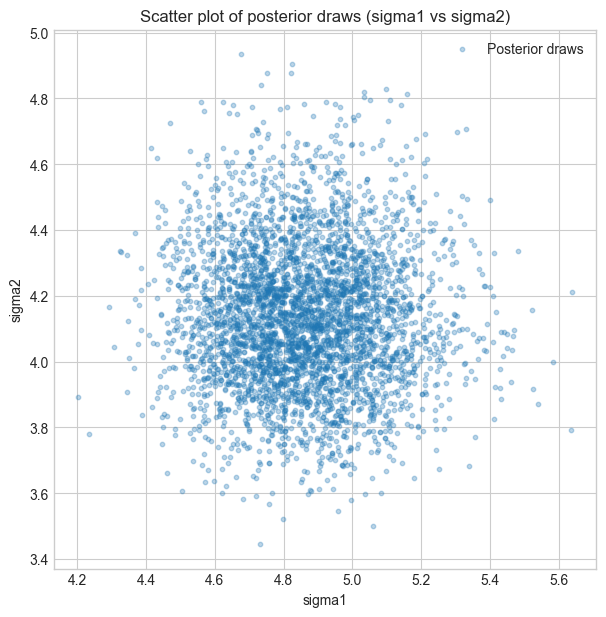

In [108]:
plt.figure(figsize=(7, 7))
plt.scatter(draws_unequal_sd['sigma1'], draws_unequal_sd['sigma2'], alpha=0.3, s=10, label='Posterior draws')
plt.xlabel('sigma1')
plt.ylabel('sigma2')
plt.title('Scatter plot of posterior draws (sigma1 vs sigma2)')
plt.legend()
plt.show()

Posterior mean of sigma2 - sigma1: -0.7231


Text(0.5, 1.0, 'Posterior Distribution of Difference (sigma2 - sigma1)')

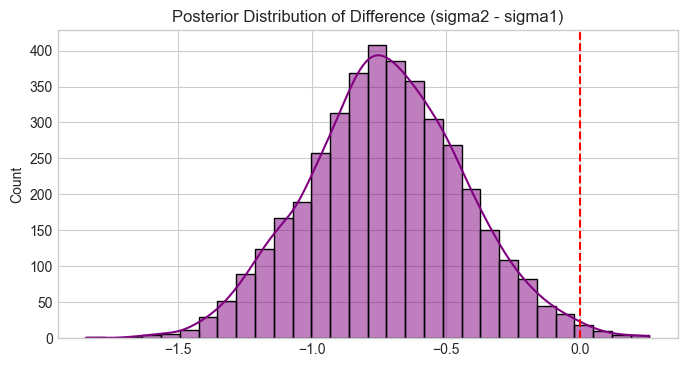

In [109]:
dsigma = draws_unequal_sd['sigma2'] - draws_unequal_sd['sigma1']
print(f"Posterior mean of sigma2 - sigma1: {dsigma.mean():.4f}")
#
plt.figure(figsize=(8, 4))
sns.histplot(dsigma, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', label='sigma2 = sigma1')
plt.title('Posterior Distribution of Difference (sigma2 - sigma1)')

---
## Many Data Points: 3000

In [110]:
# --- (1) Data Generation and Visualization ---

# Set a seed for reproducibility
rng = np.random.default_rng(123)

# Define data parameters
N1 = 3000
N2 = 2000
mean1, sd1 = 0, 5
mean2, sd2 = 1, 4

# Generate new data
Y1 = rng.normal(loc=mean1, scale=sd1, size=N1)
Y2 = rng.normal(loc=mean2, scale=sd2, size=N2)

print("--- Data Generation ---")
print(f"Generated {N1} data points for Group 1.")
print(f"Generated {N2} data points for Group 2.\n")

# Prepare data for Stan using the new data
stan_data_new = {'N1': N1, 'N2': N2, 'Y1': Y1, 'Y2': Y2}

--- Data Generation ---
Generated 3000 data points for Group 1.
Generated 2000 data points for Group 2.



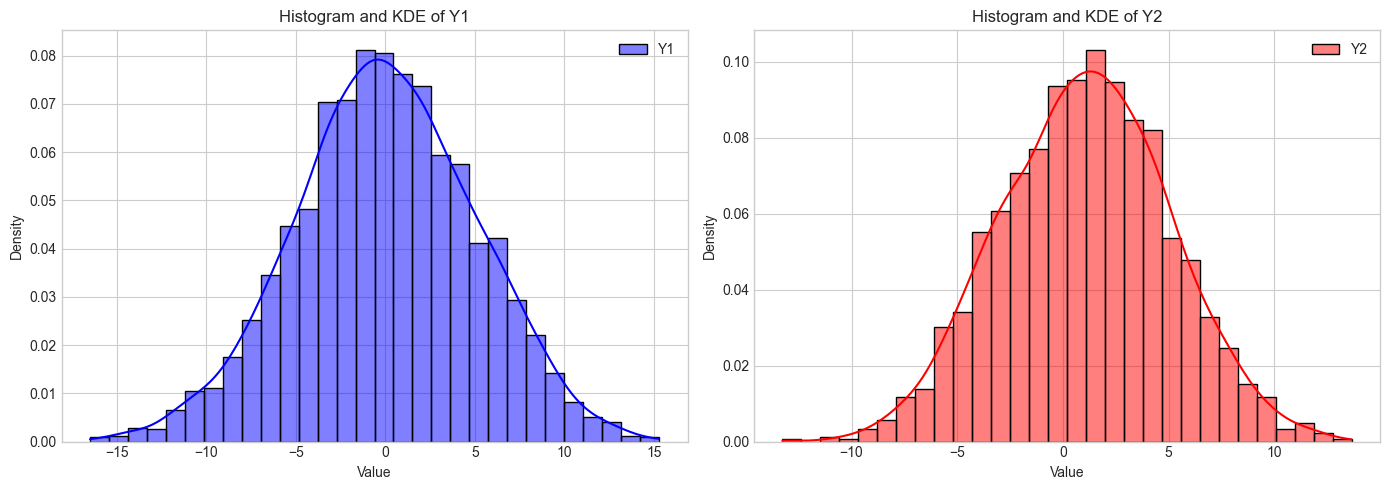

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(Y1, kde=True, color='blue', label='Y1', stat='density', bins=30, alpha=0.5, ax=axes[0])
axes[0].set_title('Histogram and KDE of Y1')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.histplot(Y2, kde=True, color='red', label='Y2', stat='density', bins=30, alpha=0.5, ax=axes[1])
axes[1].set_title('Histogram and KDE of Y2')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

In [112]:
# --- (5) Model with Unequal SD (Welch's t-test equivalent) ---
print("--- Model 2: Assuming Unequal Standard Deviations ---")
print("Fitting model...")
fit_unequal_sd_many = model_unequal_sd.sample(data=stan_data_new, seed=123, chains=4, parallel_chains=4)


12:10:59 - cmdstanpy - INFO - CmdStan start processing


--- Model 2: Assuming Unequal Standard Deviations ---
Fitting model...


chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


12:11:00 - cmdstanpy - INFO - CmdStan done processing.


In [113]:
fit_unequal_sd_many.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-10107.300000,0.030767,1.439900,1.246870,-10110.200000,-10106.900000,-10105.60000,2245.94,3029.51,10495.1,1.00264
mu1,-0.001695,0.001388,0.092269,0.092757,-0.154173,-0.001906,0.15069,4425.61,3153.57,20680.4,1.00005
mu2,1.056230,0.001433,0.089288,0.087093,0.910199,1.056420,1.19999,3926.77,2793.40,18349.4,1.00081
sigma1,5.032960,0.000934,0.065662,0.064362,4.927350,5.032250,5.14402,4997.64,3159.75,23353.5,1.00116
sigma2,3.977970,0.000857,0.062477,0.060700,3.877570,3.975560,4.08449,5376.03,3208.35,25121.7,1.00020


In [114]:
# Compute Prob[mu1 < mu2] for the unequal SD model
draws_unequal_sd = fit_unequal_sd_many.draws_pd()
prob_mu1_lt_mu2_unequal = (draws_unequal_sd['mu1'] < draws_unequal_sd['mu2']).mean()

print("\n--- Analysis for Unequal SD Model ---")
print(f"Probability (mu1 < mu2): {prob_mu1_lt_mu2_unequal:.4f}\n")

# Clean up the created Stan files
print("Cleaned up temporary .stan files.")


--- Analysis for Unequal SD Model ---
Probability (mu1 < mu2): 1.0000

Cleaned up temporary .stan files.


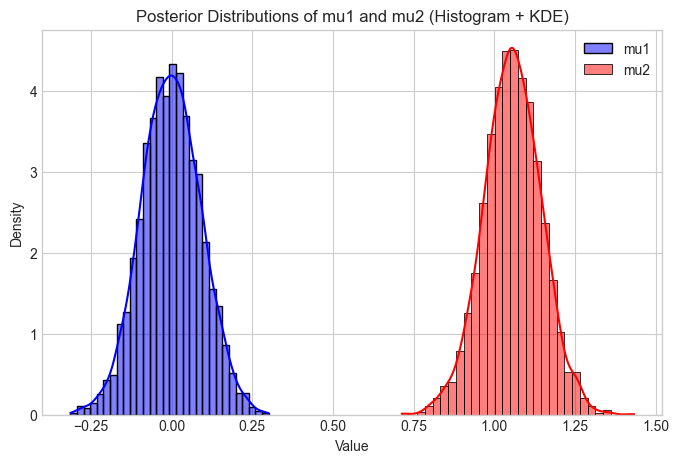

In [115]:
plt.figure(figsize=(8, 5))
sns.histplot(draws_unequal_sd['mu1'], color='blue', label='mu1', kde=True, stat='density', bins=30, alpha=0.5)
sns.histplot(draws_unequal_sd['mu2'], color='red', label='mu2', kde=True, stat='density', bins=30, alpha=0.5)
plt.title('Posterior Distributions of mu1 and mu2 (Histogram + KDE)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

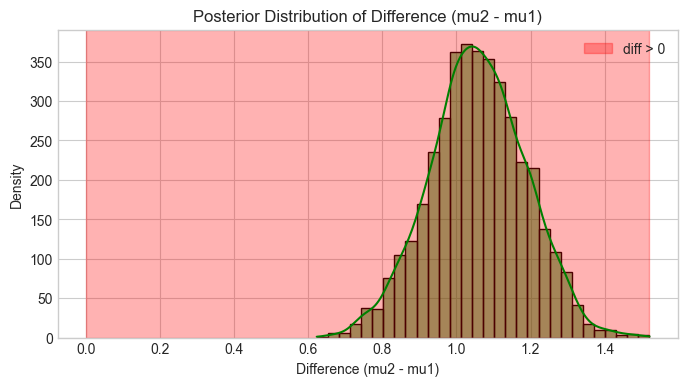

In [116]:
diff = draws_unequal_sd['mu2'] - draws_unequal_sd['mu1']
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, color='green', bins=30)
plt.axvspan(0, diff.max(), color='red', alpha=0.3, label='diff > 0')
plt.legend()
plt.title('Posterior Distribution of Difference (mu2 - mu1)')
plt.xlabel('Difference (mu2 - mu1)')
plt.ylabel('Density');

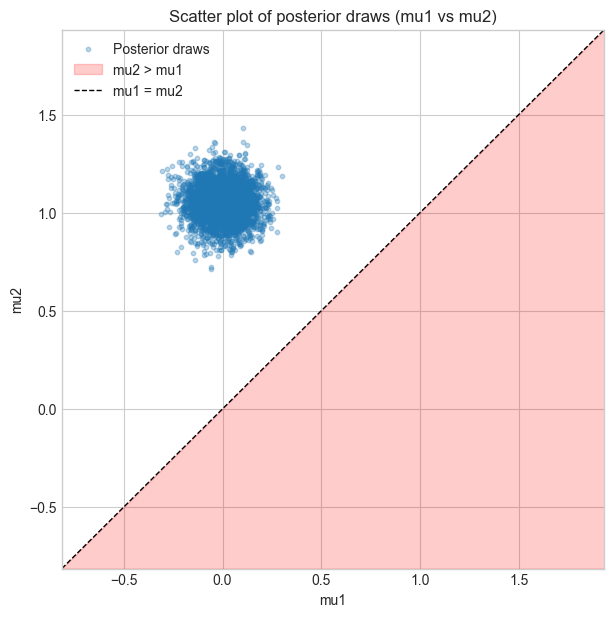

In [117]:
plt.figure(figsize=(7, 7))
plt.scatter(draws_unequal_sd['mu1'], draws_unequal_sd['mu2'], alpha=0.3, s=10, label='Posterior draws')
plt.xlabel('mu1')
plt.ylabel('mu2')
plt.title('Scatter plot of posterior draws (mu1 vs mu2)')

# Fill the region where mu2 > mu1
lims = (min(draws_unequal_sd['mu1'].min(), draws_unequal_sd['mu2'].min()) - .5,
        max(draws_unequal_sd['mu1'].max(), draws_unequal_sd['mu2'].max()) + .5)
# lims = plt.gca().get_xlim()
plt.fill_betweenx(
    y=np.linspace(*lims, 100),
    x1=np.linspace(*lims, 100),
    x2=lims[1],
    color='red',
    alpha=0.2,
    label='mu2 > mu1'
)
plt.plot(lims, lims, 'k--', lw=1, label='mu1 = mu2')
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.show()

## Classical t-test

In [118]:
from scipy.stats import ttest_ind

print("--- Classical t-test ---")
print("Data Sizes: ", Y1.shape, Y2.shape)

t_stat, p_value = ttest_ind(Y1, Y2, equal_var=False)
print(f"Welch's t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

--- Classical t-test ---
Data Sizes:  (3000,) (2000,)
Welch's t-test: t-statistic = -8.2798, p-value = 0.0000


The output:

Welch's t-test: t-statistic = -8.2798, p-value = 0.0000

means:

- **t-statistic**: -8.2798
  This value measures the difference between the means of `Y1` and `Y2`, accounting for unequal variances. A negative value means the mean of `Y1` is less than the mean of `Y2`.

- **p-value**: 0.0000
  - the null hypothesis is $H_0: \mu_1 = \mu_2 $
  - This is the probability of observing a difference as extreme as (or more extreme than) the one measured, assuming the null hypothesis (that the means are equal) is true.  
  - A p-value of 0.0000 is smaller than the common significance threshold (0.05), so there is **strong evidence** to reject the null hypothesis.
  - A p-value of 0.0000 means that, **if the null hypothesis were true**, the probability of observing a difference as extreme as the one in the data Y1, Y2 is **less than 0.01%**.
  - This is strong evidence against the null hypothesis.

**Conclusion:**  
  If p-value < 0.05, you **reject** the null hypothesis (strong evidence of a difference).
  

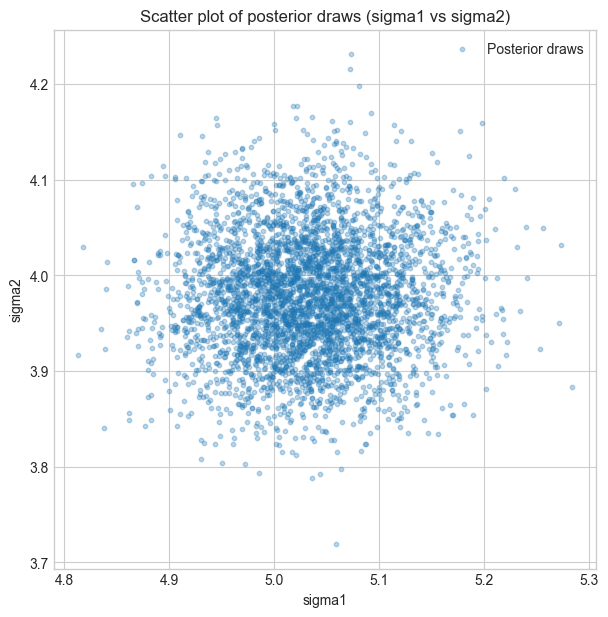

In [119]:
plt.figure(figsize=(7, 7))
plt.scatter(draws_unequal_sd['sigma1'], draws_unequal_sd['sigma2'], alpha=0.3, s=10, label='Posterior draws')
plt.xlabel('sigma1')
plt.ylabel('sigma2')
plt.title('Scatter plot of posterior draws (sigma1 vs sigma2)')
plt.legend()
plt.show()

Posterior mean of sigma2 - sigma1: -1.0550


Text(0.5, 1.0, 'Posterior Distribution of Difference (sigma2 - sigma1)')

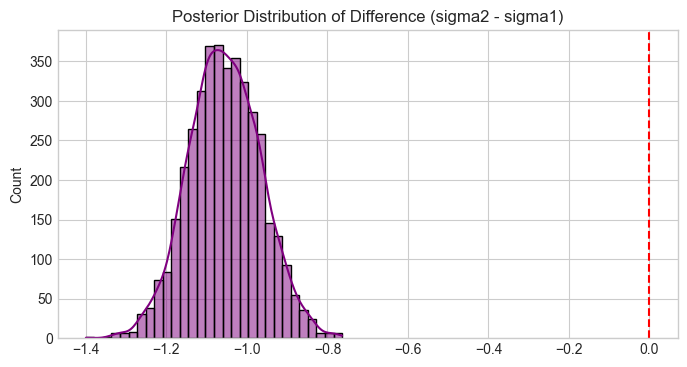

In [120]:
dsigma = draws_unequal_sd['sigma2'] - draws_unequal_sd['sigma1']
print(f"Posterior mean of sigma2 - sigma1: {dsigma.mean():.4f}")
#
plt.figure(figsize=(8, 4))
sns.histplot(dsigma, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', label='sigma2 = sigma1')
plt.title('Posterior Distribution of Difference (sigma2 - sigma1)')

End.